In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
import err_ranges
import seaborn as sns

%matplotlib inline

In [2]:
#importing datasets needed for the analysis
gdp = pd.read_csv(r'gdp.csv') #GDP per capita 
lif = pd.read_csv(r'life.csv') #life expectancy data

In [3]:
#consolidating the two dataframes 
df_80 = pd.DataFrame()
df_80['gdp'] = gdp['1980'] #taking GDP per capita of the year 1980
df_80['lif'] = lif['1980'] #taking life expectency of the year 1980

df_80.index = gdp['Country Name']

In [4]:
#Scaling the data so that the clustering algorithm can perform better 
scaler = StandardScaler()
scaler.fit(df_80)


trans_df = pd.DataFrame(scaler.transform(df_80)) #scaled dataframe

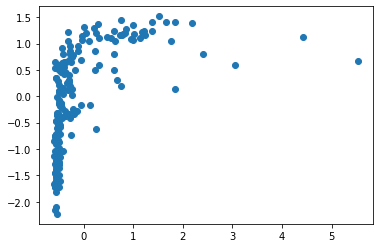

In [5]:
plt.scatter(trans_df.iloc[:,0],trans_df.iloc[:,1]) #scatterplot of scaled data

In [6]:
df_80.index = gdp['Country Name']

In [7]:
#dropping all NaN values in the data
df_80.dropna(how='any',inplace=True)

### Clustering and plotting

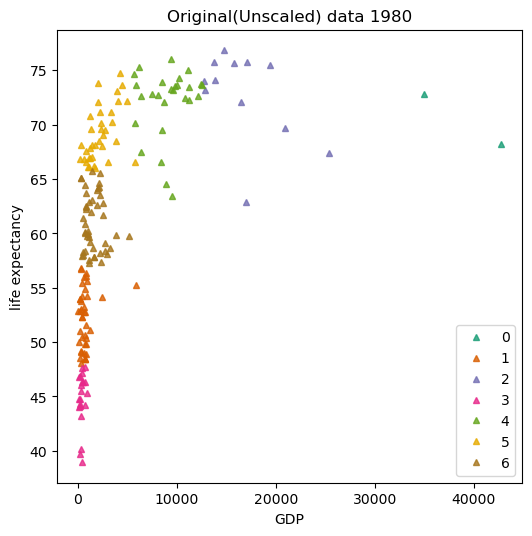

In [8]:
trans_df.dropna(how='any',inplace=True) #scaled data

#creating and fitting the clustering algorithm
ap = cluster.AffinityPropagation(max_iter=2000, preference=-5,random_state = 55) 
ap.fit(trans_df)


#defining x and y for easy plotting of the data
x = df_80['gdp']
y = df_80['lif']

#get the labels after fitting the clustering algorithm
labels = ap.labels_
cen = ap.cluster_centers_
df_80['labels'] = labels #label the data for further analysis


#plotting the data colorcoded with respective labels
plt.figure(figsize=(6,6),dpi=100)

palette = sns.color_palette('Dark2', len(cen)) #setting a color palette 

for l in range(0, len(cen)):     # loop over the different labels
    plt.plot(x[labels==l], y[labels==l], "^", markersize=5,label=l,color=palette[l],alpha=0.8)

plt.xlabel("GDP")
plt.ylabel("life expectancy")
plt.title('Original(Unscaled) data 1980')
plt.legend()
plt.show()

# GDP 

lets select a group and 

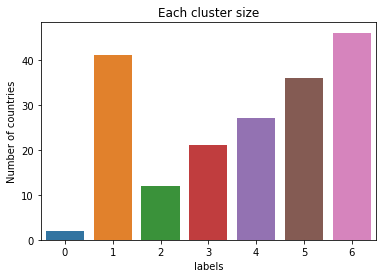

In [9]:
sns.countplot(x =df_80.labels) #countplot
plt.title('Each cluster size')
plt.ylabel('Number of countries')
plt.show()

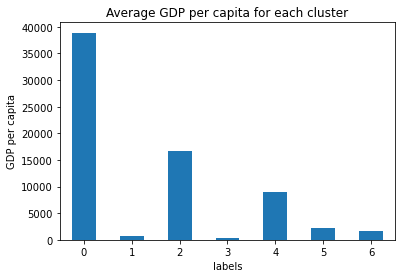

In [10]:
df_80.groupby(['labels'])['gdp'].mean().plot(kind ='bar') #barplot
plt.title('Average GDP per capita for each cluster')
plt.ylabel('GDP per capita')
plt.xticks(rotation=0)
plt.show()

This plot shows us that most countries fall under the last cluster which has very low mean. 

We can compare the gdp of a country from first group with the last group which are smallest and largest clusters respectively. 

In [11]:
#Displaying the countries in the cluster

print("first cluster:",df_80[df_80.labels ==0].index,'\n')
print("second cluster:",df_80[df_80.labels ==6].index)

first cluster: Index(['United Arab Emirates', 'Qatar'], dtype='object', name='Country Name') 

second cluster: Index(['Arab World', 'Brazil', 'Botswana', 'Cabo Verde', 'Dominican Republic',
       'Algeria', 'East Asia & Pacific (excluding high income)', 'Ecuador',
       'Egypt, Arab Rep.', 'Fiji', 'Guatemala', 'Guyana', 'Honduras',
       'IBRD only', 'IDA & IBRD total', 'Indonesia', 'Iraq', 'Kenya',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & Caribbean', 'Low & middle income', 'Morocco',
       'Middle East & North Africa', 'Middle income',
       'Middle East & North Africa (excluding high income)', 'Namibia',
       'Nicaragua', 'Oman', 'Other small states', 'Peru', 'Philippines',
       'Pacific island small states', 'Solomon Islands', 'Small states',
       'Suriname', 'Syrian Arab Republic',
       'East Asia & Pacific (IDA & IBRD countries)', 'Thailand',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Middle East &

Since UAE is in middle east it will be interesting to compare UAE with 'Middle East and North Africa'. 

In [12]:
#creating dataset for fitting and predicting


    #taking UAE GDP for all the available years.
df_final = gdp[gdp['Country Name'] == 'United Arab Emirates'].drop(gdp.columns[:4],axis =1).T.reset_index()
    #taking Middle East and North Africa GDP for all the available years.
df_final['mena'] = gdp[gdp['Country Name'] == 'Middle East & North Africa'].drop(gdp.columns[:4],axis=1).T.reset_index(drop=True)

    #naming the columns
df_final.columns = ['years','uae','mena'] 

    #dropping all the rows with missing values
df_final.dropna(how='any',inplace=True)

    #converting the years column into numeric
df_final.years = pd.to_numeric(df_final.years)

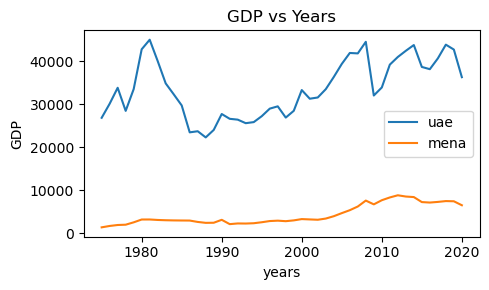

In [14]:
#setting global plot parameters
plt.rcParams["figure.dpi"] = 100

#plotting the data
df_final.plot('years',['uae','mena'],figsize=[5,3])

plt.title('GDP vs Years')
plt.ylabel('GDP')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Defining functions to use in curve_fit

In [15]:
def exponential(t, n0, g):
    """Calculates exponential function with scale factor n0 and growth rate g."""
    
    t = t - 1960.0
    f = n0 * np.exp(g*t)
    
    return f

In [16]:
def logistic(t, n0, g, t0):
    """Calculates the logistic function with scale factor n0 and growth rate g"""
    
    f = n0 / (1 + np.exp(-g*(t - t0)))
    
    return f

In [17]:
def poly(x,a,b,c): 
    """Calculates the polynomial function with parameters a,b,c"""
    
    y = a*x**2 + b*x + c
    
    return y

In [18]:
param, covar = curve_fit(exponential, df_final["years"], df_final["uae"],maxfev=2000,p0=(df_80.groupby(['labels'])['gdp'].min()[0], 0.03))


In [19]:
def plot_fitted(df,i,param,covar): 
    
    sigma = np.sqrt(np.diag(covar)) #calculating the sigma value
    
    year = np.arange(1975, 2031) #defining range of years for prediction
    forecast = exponential(year, *param) #predicting
    
    #calculating the upper and lower intervals
    low, up = err_ranges.err_ranges(year, exponential, param, sigma)
    
    #plotting the figure
    plt.figure()
    
    plt.plot(df.years,df[i],label=i,color='green') #original data

    plt.plot(year, forecast, label="forecast",linestyle = '--') #fitted data
    
    #filling color between the confidence intervals
    plt.fill_between(year, low, up, color="maroon", alpha=0.1)
    plt.xlabel("year")
    plt.ylabel("GDP")
    plt.legend()

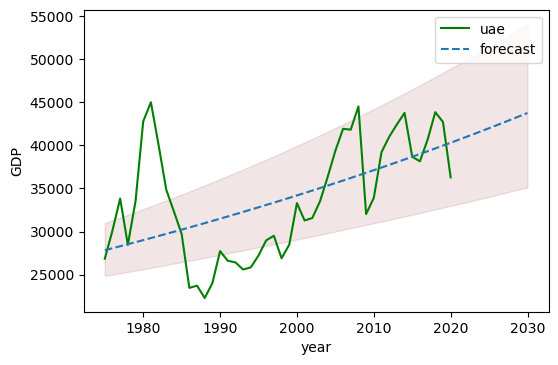

In [20]:
plot_fitted(df_final,i='uae',param = param,covar = covar)

In [21]:
param1, covar1 = curve_fit(exponential, df_final["years"], df_final["mena"],maxfev=2000,p0=(df_80.groupby(['labels'])['gdp'].min()[0], 0.03))


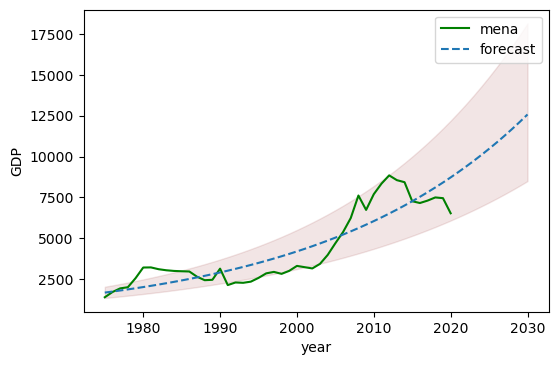

In [22]:
plot_fitted(df_final,i='mena',param=param1,covar=covar1)